In [1]:
import numpy as np
import pandas as pd
import scipy.constants as cst
import scipy.special as spc
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [2]:
lamda = 1064*10**(-9) #wavelength in nm
k_lamda=2*np.pi/lamda
m_Rb=1.44316*10**(-25) #in kg
Er=(cst.hbar*k_lamda)**2/(2*m_Rb)/cst.h/10**3 #in kHz
print(Er)
V0=8.0
scatterlength=100.4*cst.physical_constants['Bohr radius'][0]
g2D=np.sqrt(8*np.pi)*cst.hbar**2*scatterlength/(m_Rb*np.sqrt(cst.hbar/(m_Rb*(2*np.pi*21.09*1000))))

2.027814796121164


In [14]:
def geteigen(V0,q,bandnum=201):
    s=(2*np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)+q)**2+0.5*V0
    hamiltonian=np.diag([-0.25*V0]*(bandnum-1),-1)+np.diag([-0.25*V0]*(bandnum-1),1)+np.diag(s)
    val,vec=np.linalg.eigh(hamiltonian)
    seq=np.argsort(val)
    return val[seq],vec.transpose()[seq]

def blochfunction(V0,q,n,x,xi,bandnum=201):
    x=np.array(x)
    basevec=geteigen(V0,q,bandnum)[1][n]#/np.sum(geteigen(V0,q,bandnum)[1],axis=0).reshape(bandnum)
    #print(basevec)
    sumlist=np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)
    #print(np.exp(2j*k_lamda*sumlist*x)*basevec)
    sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*np.exp(2j*k_lamda*lamda*np.dot(sumlist.reshape(1,len(sumlist)).transpose(),x.reshape(1,len(x)))).transpose(),axis=1)
    #sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))
    #print(1j*q*k_lamda*lamda*x)
    #print(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))
    #print(sumfourier)
    if n%2==0:
        angle=np.exp(-1j*np.angle(np.exp(-1j*q*k_lamda*xi*lamda)*np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
        #print(np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    else:
        angle=np.exp(-1j*np.angle(np.exp(-1j*q*k_lamda*xi*lamda)*np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+0*1j*q*k_lamda*lamda)*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    #print(np.exp(1*1j*q*k_lamda*0.25*lamda)*np.sum(basevec*np.exp(1j*k_lamda*sumlist*0.25*lamda)))
    
    sumfourier=sumfourier*angle
    return sumfourier   

def blochfunctionderiv2(V0,q,n,x,xi,bandnum=201):
    x=np.array(x)
    basevec=geteigen(V0,q,bandnum)[1][n]#/np.sum(geteigen(V0,q,bandnum)[1],axis=0).reshape(bandnum)
    #print(basevec)
    sumlist=np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)
    #print(np.exp(2j*k_lamda*sumlist*x)*basevec)
    sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+1*1j*q*k_lamda*lamda)**2*np.exp(2j*k_lamda*lamda*np.dot(sumlist.reshape(1,len(sumlist)).transpose(),x.reshape(1,len(x)))).transpose(),axis=1)
    #sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+1*1j*q*k_lamda*lamda)**2*np.exp(2j*k_lamda*lamda*sumlist*x))
    #print(1j*q*k_lamda*lamda*x)
    #print(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))    
    if n%2==0:
        angle=np.exp(-1j*np.angle(np.exp(-1j*q*k_lamda*xi*lamda)*np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
        #print(np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    else:
        angle=np.exp(-1j*np.angle(np.exp(-1j*q*k_lamda*xi*lamda)*np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+0*1j*q*k_lamda*lamda)*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    #print(np.exp(1*1j*q*k_lamda*0.25*lamda)*np.sum(basevec*np.exp(1j*k_lamda*sumlist*0.25*lamda)))
    sumfourier=sumfourier#*angle
    return sumfourier   

def WannierState(V0,n,x,xi,bandnum=201):
    qlist=np.linspace(-1,1,501)
    bl=[]
    for q in qlist:
        bl.append(blochfunction(V0,q,n,x,xi,bandnum=bandnum)*np.exp(-1j*q*xi*2*np.pi))
    #print(len(qlist),bl.shape)
    bl=np.array(bl)
    ws=integrate.simps(bl,qlist,axis=0)
    #s=integrate.simps(np.abs(ws)**2,x)*lamda
    return ws

def WannierStatederiv2(V0,n,x,xi,bandnum=201):
    qlist=np.linspace(-1,1,501)
    bl=[]
    #bl1=[]
    for q in qlist:
        bl.append(blochfunctionderiv2(V0,q,n,x,xi,bandnum=bandnum)*np.exp(-1j*q*xi*2*np.pi))
        #bl1.append(blochfunction(V0,q,n,x,xi,bandnum=bandnum)*np.exp(-1j*q*xi*2*np.pi))
    #print(len(qlist),bl.shape)
    bl=np.array(bl)
    #bl1=np.array(bl1)
    ws=integrate.simps(bl,qlist,axis=0)/lamda**2
    #ws1=integrate.simps(bl1,qlist,axis=0)
    #s=integrate.simps(np.abs(ws1)**2,x)*lamda
    return ws

def tunnellingappro(V0,n,bandnum=201):
    ttight=(geteigen(V0,1,bandnum=bandnum)[0][n]-geteigen(V0,0,bandnum=bandnum)[0][n])/4*1000*Er
    return ttight

def tunnellingol(V0,n,bandnum=201):
    xl=np.linspace(-3,3,401)
    s1=WannierState(V0,n,xl,0.,bandnum=bandnum)
    s3=WannierState(V0,n,xl,0.5,bandnum=bandnum)
    s2=WannierStatederiv2(V0,n,xl,0.5,bandnum=bandnum)
    toverlap=-(-1*cst.hbar**2/(2*m_Rb)*integrate.simps(np.conj(s1)*s2,xl)/cst.h/np.sqrt(integrate.simps(np.abs(s1)**2,xl)*integrate.simps(np.abs(s3)**2,xl))
               +1*integrate.simps(np.conj(s1)*V0*1000*Er*(1-np.cos(k_lamda*xl*lamda)**2)*s3,xl)/np.sqrt(integrate.simps(np.abs(s1)**2,xl)*integrate.simps(np.abs(s3)**2,xl)))
    return toverlap

def tunnellingsum(V0,n,bandnum=201):
    qlist=np.linspace(0,2,501)
    eivallist=[]
    for q in qlist:
        eivallist.append(geteigen(V0,q,bandnum=bandnum)[n])
    eivallist=np.array(eivallist)
    return -np.real(integrate.simps((eivallist[:,0])*np.exp(-1j*qlist*np.pi),0.5*qlist)*Er*10**3)

def interaction(Vx,Vy,Vz,n,bandnum=201):
    xl=np.linspace(-2,2,301)
    dx=xl[1]-xl[0]
    s1=WannierState(Vx,n,xl,0,bandnum=bandnum)
    s2=WannierState(Vy,n,xl,0,bandnum=bandnum)
    s3=WannierState(Vz,n,xl,0,bandnum=bandnum)
    s11=integrate.simps(np.abs(s1)**2,xl)*lamda
    s21=integrate.simps(np.abs(s2)**2,xl)*lamda
    s31=integrate.simps(np.abs(s3)**2,xl)*lamda
    inte=4*np.pi*cst.hbar**2*scatterlength/m_Rb*integrate.simps(np.abs(s1)**4,xl)*integrate.simps(np.abs(s2)**4,xl)*integrate.simps(np.abs(s3)**4,xl)*(lamda)**3/cst.h/(s11*s21*s31)**2
    return inte

def interaction2d(Vx,Vy,Vz,n,bandnum=201):
    xl=np.linspace(-2,2,701)
#     dx=xl[1]-xl[0]
#     s1=WannierState(Vx,n,xl,0,bandnum=bandnum)
#     s2=WannierState(Vy,n,xl,0,bandnum=bandnum)
    s3=WannierState(Vz,n,xl,0,bandnum=bandnum)
#     s11=integrate.simps(np.abs(s1)**2,xl)*lamda
#     s21=integrate.simps(np.abs(s2)**2,xl)*lamda
    s31=integrate.simps(np.abs(s3)**2,xl)*lamda
#     print(integrate.simps(np.abs(s3)**2,xl)*(lamda)/(s31))
    inte=4*np.pi*cst.hbar**2*scatterlength/m_Rb*integrate.simps(np.abs(s3)**4,xl)*(lamda)/(s31)**2
    return inte

def interaction2(Vx,Vy,Vz,n,bandnum=201):
    xl=np.linspace(-2,2,301)
    s1=WannierState(Vx,n,xl,0,bandnum=bandnum)
    s2=WannierState(Vy,n,xl,0,bandnum=bandnum)
    s3=WannierState(Vz,n,xl,0,bandnum=bandnum)
    s11=integrate.simps(np.abs(s1)**2,xl)*lamda
    s21=integrate.simps(np.abs(s2)**2,xl)*lamda
    s31=integrate.simps(np.abs(s3)**2,xl)*lamda
    inte=g2D*integrate.simps(np.abs(s1)**4,xl)*integrate.simps(np.abs(s2)**4,xl)*(lamda)**2/cst.h/(s11*s21)**2
    return inte

def DensityDependentInteraction(Vx,Vy,Vz,n,bandnum=201):
    xl=np.linspace(-3,3,501)
    dx=xl[1]-xl[0]
    s1=WannierState(Vx,n,xl,0,bandnum=bandnum)
    s12=WannierState(Vx,n,xl,-0.5,bandnum=bandnum)
    s2=WannierState(Vy,n,xl,0,bandnum=bandnum)
    s3=WannierState(Vz,n,xl,0,bandnum=bandnum)
    s11=integrate.simps(np.abs(s1)**2,xl)*lamda
    s21=integrate.simps(np.abs(s2)**2,xl)*lamda
    s31=integrate.simps(np.abs(s3)**2,xl)*lamda
    inte=-4*np.pi*cst.hbar**2*scatterlength/m_Rb*integrate.simps(np.abs(s1)**2*np.conj(s1)*s12,xl)*integrate.simps(np.abs(s2)**4,xl)*integrate.simps(np.abs(s3)**4,xl)*(lamda)**3/cst.h/(s11*s21*s31)**2
    return inte

def PairTunneling(Vx,Vy,Vz,n,bandnum=201):
    xl=np.linspace(-3,3,501)
    dx=xl[1]-xl[0]
    s1=WannierState(Vx,n,xl,0,bandnum=bandnum)
    s12=WannierState(Vx,n,xl,-0.5,bandnum=bandnum)
    s2=WannierState(Vy,n,xl,0,bandnum=bandnum)
    s3=WannierState(Vz,n,xl,0,bandnum=bandnum)
    s11=integrate.simps(np.abs(s1)**2,xl)*lamda
    s21=integrate.simps(np.abs(s2)**2,xl)*lamda
    s31=integrate.simps(np.abs(s3)**2,xl)*lamda
    inte=4*np.pi*cst.hbar**2*scatterlength/m_Rb*integrate.simps(np.conj(s1)**2*s12**2,xl)*integrate.simps(np.abs(s2)**4,xl)*integrate.simps(np.abs(s3)**4,xl)*(lamda)**3/cst.h/(s11*s21*s31)**2
    return inte


In [4]:
%%time
vlist=np.linspace(9.9,10.6,10)
Ui1=[interaction(v,v,27,0,bandnum=11) for v in vlist]
Ui2=[interaction2(v,v,27,0,bandnum=11) for v in vlist]
Ui3=[interaction2d(v,v,27,0,bandnum=11) for v in vlist]

KeyboardInterrupt: 

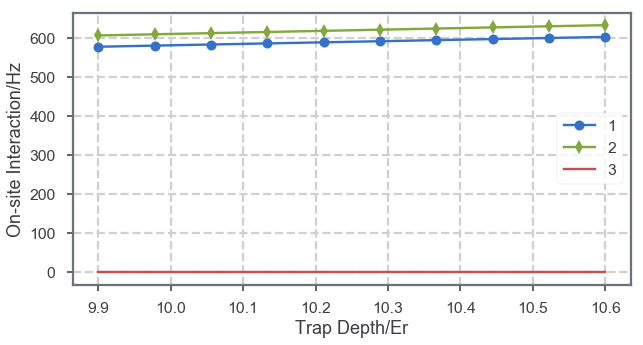

In [5]:
plt.figure(figsize=(10,5))
plt.xlabel('Trap Depth/Er')
plt.ylabel('On-site Interaction/Hz')
plt.plot(vlist,Ui1,'-o',markersize=10,label='1')
plt.plot(vlist,Ui2,'-d',markersize=10,label='2')
plt.plot(vlist,Ui3,'-x',markersize=10,label='3')
plt.legend()
#plt.plot(vlist,Ui2,'-d',markersize=10)
#plt.plot(vlist,Uli*10**-9*cst.Boltzmann/cst.h,'-o',markerfacecolor='w',markersize=5,markeredgecolor='y')

/Users/boxiao/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


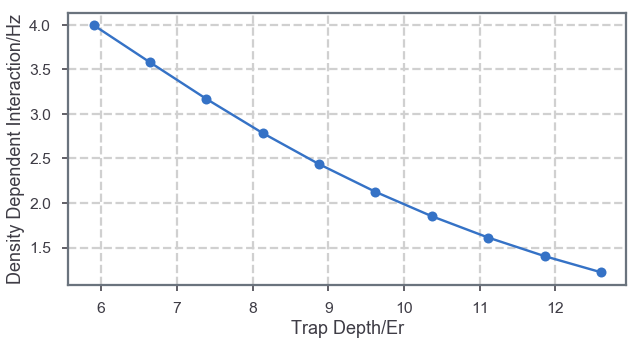

In [13]:
vlist2=np.linspace(5.9,12.6,10)
Udensity=[DensityDependentInteraction(v,v,27,0,bandnum=11) for v in vlist2]
plt.figure(figsize=(10,5))
plt.xlabel('Trap Depth/Er')
plt.ylabel('Density Dependent Interaction/Hz')
plt.plot(vlist2,Udensity,'-o',markersize=10,label='Density')

/Users/boxiao/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


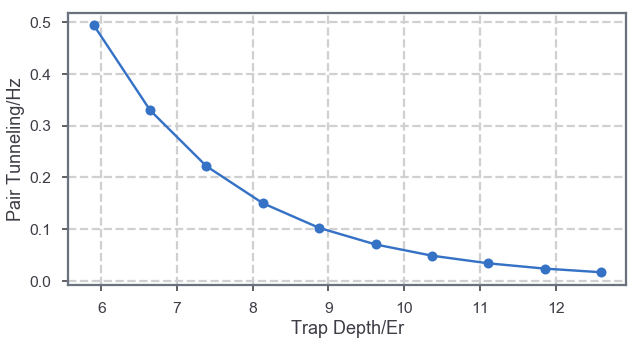

In [18]:
vlist2=np.linspace(5.9,12.6,10)
Upair=[PairTunneling(v,v,27,0,bandnum=11) for v in vlist2]
plt.figure(figsize=(10,5))
plt.xlabel('Trap Depth/Er')
plt.ylabel('Pair Tunneling/Hz')
plt.plot(vlist2,Upair,'-o',markersize=10,label='Pair')

In [34]:
%%time
#xl=np.linspace(-1,1,100)
#s=integrate.simps([np.conj(-WannierState(8,0,x,0,bandnum=11))*WannierStatederiv2(8,0,x,0.5,bandnum=11) for x in xl],xl)
v=np.linspace(9.9,10.6,20)
tband=[tunnellingappro(V0,0,bandnum=11) for V0 in v]
tovr=[tunnellingol(V0,0,bandnum=11) for V0 in v]
tsum=[tunnellingsum(V0,0,bandnum=11) for V0 in v]
Ui=[interaction(v,v,27,0,bandnum=11) for v in v]
#print(s,t)

CPU times: user 47.5 s, sys: 776 ms, total: 48.3 s
Wall time: 24.7 s


/Users/boxiao/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


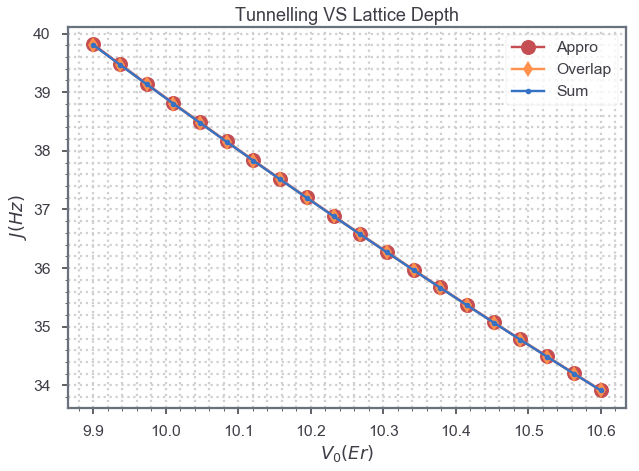

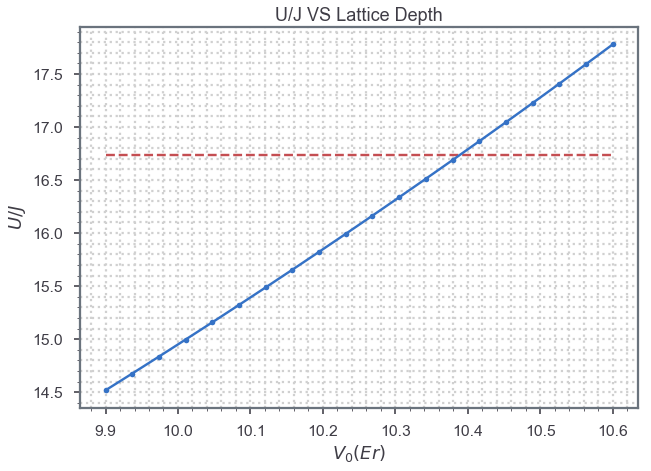

In [135]:
v=np.linspace(9.9,10.6,20)
plt.figure(figsize=(10,7))
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
#plt.yscale('log')
plt.title('Tunnelling VS Lattice Depth')
plt.xlabel('$V_{0}(Er)$')
plt.ylabel('$J(Hz)$')
plt.plot(v,np.array(tband),'r-o',markersize=15)
plt.plot(v,np.array(tovr),'y-d')
plt.plot(v,np.array(tsum),'.-')
plt.legend(['Appro','Overlap','Sum'],loc='best')

plt.figure(figsize=(10,7))
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
#plt.yscale('log')
plt.title('U/J VS Lattice Depth')
plt.hlines(16.74,9.9,10.6,colors='r', linestyles='dashed')
plt.xlabel('$V_{0}(Er)$')
plt.ylabel('$U/J$')
plt.plot(v,Ui/np.array(tovr),'.-')

In [12]:
%%time
xl=np.linspace(-2,2,300)
s=integrate.simps(np.abs(WannierState(8,0,xl,0,bandnum=31))**2,xl)
print(s)

1.9999999999972333
CPU times: user 818 ms, sys: 32 ms, total: 850 ms
Wall time: 512 ms


The gap between third band and second band is 13.56 kHz when trap depth is 8.0 Er


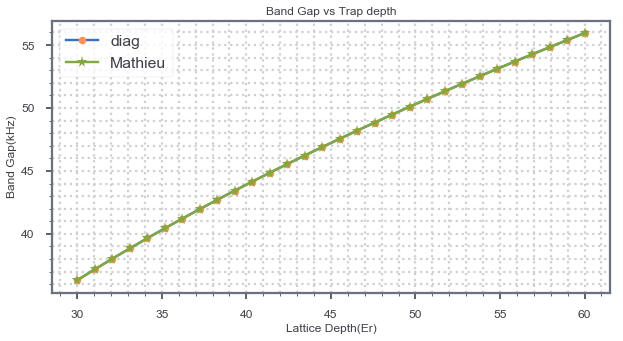

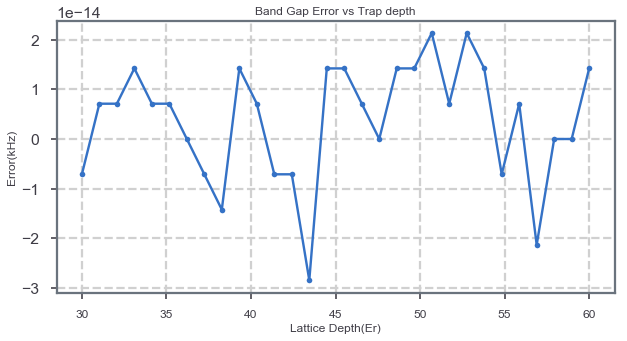

In [5]:
bandgap20=geteigen(V0,0)[0][2]-geteigen(V0,0)[0][0]
print('The gap between third band and second band is %0.2f kHz when trap depth is %2.1f Er'%(bandgap20*Er,V0))
qlist=np.linspace(-1,1,50)
eivallist=[]
for q in qlist:
    eivallist.append(geteigen(V0,q)[0])
eivallist=np.array(eivallist)

v=np.linspace(30,60,30)
plt.figure(figsize=(10,5))
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.title('Band Gap vs Trap depth',fontsize=12)
plt.xlabel('Lattice Depth(Er)',fontsize=12)
plt.ylabel('Band Gap(kHz)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(35,55,5),fontsize=12)
plt.plot(v,[(geteigen(v0,0)[0][2]-geteigen(v0,0)[0][0])*Er for v0 in v],'.-',mfc='y',mec='b',markersize=15,label='diag')
plt.plot(v,(spc.mathieu_a(2,-v/4)-spc.mathieu_a(0,-v/4))*Er,'*-',label='Mathieu')
plt.legend(loc='best')

plt.figure(figsize=(10,5))
plt.xlabel('Lattice Depth(Er)',fontsize=12)
plt.ylabel('Error(kHz)',fontsize=12)
plt.title('Band Gap Error vs Trap depth',fontsize=12)
plt.xticks(fontsize=12)
#plt.yticks(np.linspace(35,55,5),fontsize=12)
plt.plot(v,(spc.mathieu_a(2,-v/4)-spc.mathieu_a(0,-v/4))*Er-[(geteigen(v0,0)[0][2]-geteigen(v0,0)[0][0])*Er for v0 in v],'.-',label='Mathieu')

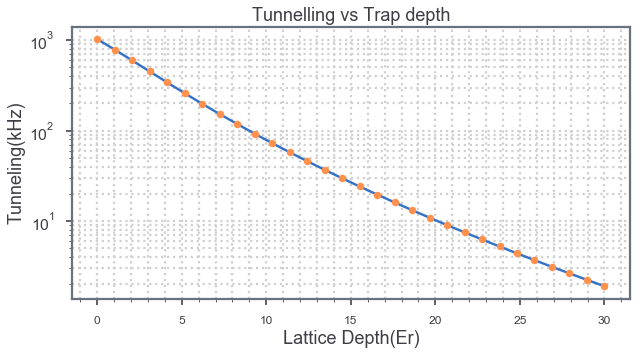

In [6]:
v=np.linspace(0,30,30)
plt.figure(figsize=(10,5))
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
plt.title('Tunnelling vs Trap depth')
plt.xlabel('Lattice Depth(Er)')
plt.ylabel('Tunneling(kHz)')
plt.xticks(fontsize=12)
plt.yscale('log')
#plt.yticks(np.linspace(35,55,5),fontsize=12)
plt.plot(v,[tunnellingappro(V0,0,bandnum=201)*Er for V0 in v],'.-',mfc='y',mec='b',markersize=15,label='diag')

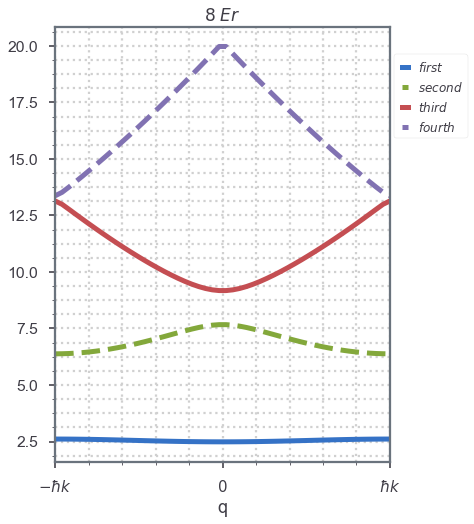

In [7]:
plt.figure(figsize=(6,8),linewidth=22)#,facecolor='w')
plt.minorticks_on()
plt.grid(True, which='both',linestyle='dotted')
#plt.subplots_adjust(right=0.7) 
plt.xlim(-1,1)
plt.xticks(np.linspace(-1,1,3), ('$-\hbar k$','$0$','$\hbar k$'),fontsize='15')
plt.title('$%0.0f$ $Er$'%(V0),fontsize='17')
plt.xlabel('q')
#plt.yticks(np.linspace(-12,12,11),fontsize='15')
plt.plot(qlist,eivallist[:,0],'.-',
         qlist,eivallist[:,1],'--',
         qlist,eivallist[:,2],'.-',
         qlist,eivallist[:,3],'--',linewidth=5,markersize=5)
plt.legend(['$first$','$second$','$third$','$fourth$'],loc='best',
           fontsize='12',bbox_to_anchor=(1.25,0.95), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)
plt.savefig('BandStructure.pdf',bbox_inches='tight')
plt.show()

CPU times: user 62.6 ms, sys: 4.29 ms, total: 66.9 ms
Wall time: 51.5 ms


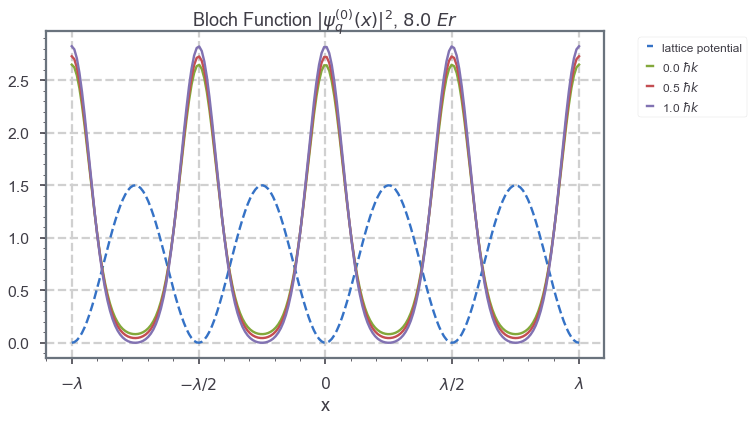

In [8]:
%%time
bandnum=11
xlist=np.linspace(-1,1,200)
plt.figure(figsize=(10,6))
plt.minorticks_on()
#plt.grid(True, which='both',linestyle='-')
plt.xlabel('x')
plt.title('Bloch Function $|\psi^{(0)}_{q}(x)|^2$, $%1.1f$ $Er$'%V0)
plt.xticks(np.linspace(-1,1,5),('$-\lambda$','$-\lambda/2$','$0$','$\lambda/2$','$\lambda$'))
qlist=[0,0.5,1]
plt.plot(xlist,1.5*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for q in qlist:
    plt.plot(xlist,(np.abs(blochfunction(V0,q,0,xlist,0.5,bandnum=bandnum)))**2,'-',label='%1.1f $\hbar k$'%q)
plt.legend(loc='best',bbox_to_anchor=(1.05,1.00), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 189 ms, sys: 7.35 ms, total: 196 ms
Wall time: 152 ms


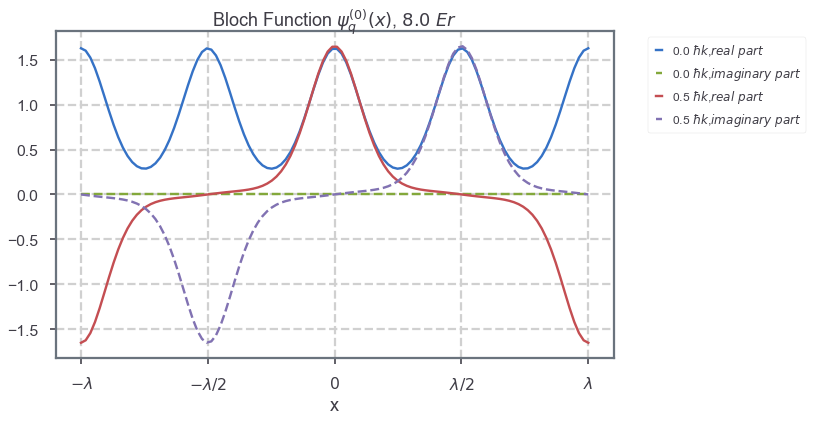

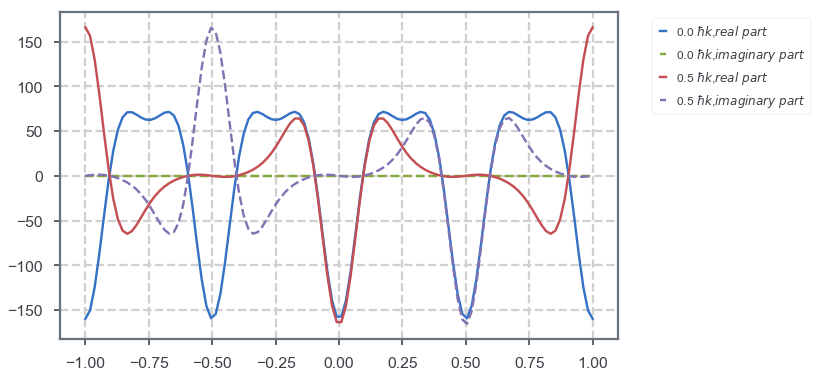

In [9]:
%%time
bandnum=11
xlist=np.linspace(-1,1,110)
plt.figure(figsize=(10,6))
plt.title('Bloch Function $\psi^{(0)}_{q}(x)$, $%1.1f$ $Er$'%V0)
plt.xlabel('x')
plt.grid(True)
qlist=[0,0.5]
plt.xticks(np.linspace(-1,1,5),('$-\lambda$','$-\lambda/2$','$0$','$\lambda/2$','$\lambda$'))
for q in qlist:
    plt.plot(xlist,np.real(blochfunction(V0,q,0,xlist,0.5,bandnum=bandnum)),'-',label='%1.1f $\hbar k$,$real\\ part$'%q)
    plt.plot(xlist,np.imag(blochfunction(V0,q,0,xlist,0.5,bandnum=bandnum)),'--',label='%1.1f $\hbar k$,$imaginary\\ part$'%q)
plt.legend(loc='best',bbox_to_anchor=(1.05,1.00), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

plt.figure(figsize=(10,6))
for q in qlist:
    plt.plot(xlist,np.real(blochfunctionderiv2(V0,q,0,xlist,0.5,bandnum=bandnum)),'-',label='%1.1f $\hbar k$,$real\\ part$'%q)
    plt.plot(xlist,np.imag(blochfunctionderiv2(V0,q,0,xlist,0.5,bandnum=bandnum)),'--',label='%1.1f $\hbar k$,$imaginary\\ part$'%q)
plt.legend(loc='best',bbox_to_anchor=(1.05,1.00), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 4.37 s, sys: 104 ms, total: 4.47 s
Wall time: 2.6 s


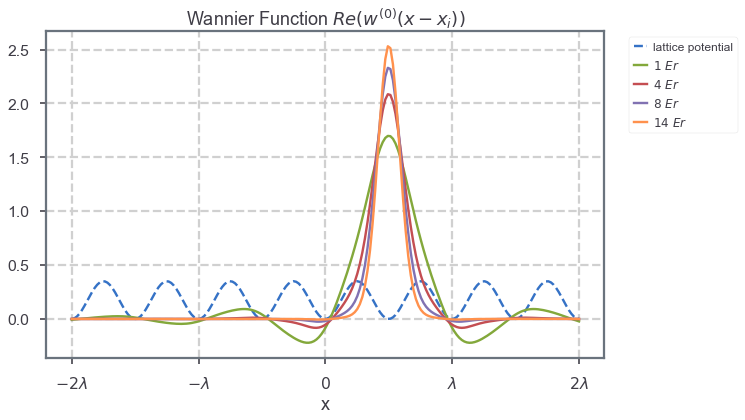

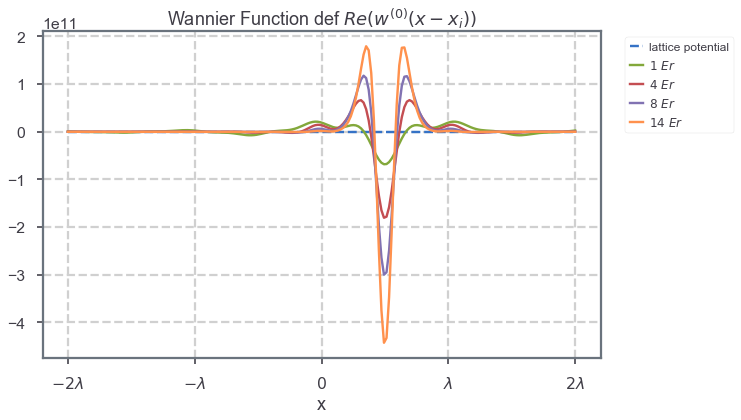

In [10]:
%%time
bandnum=11
xlist=np.linspace(-2,2,200)
#plt.grid(True)
vlist=[1,4,8,14]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $Re(w^{(0)}(x-x_i))$')
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for v in vlist:
    plt.plot(xlist,np.real(WannierState(v,0,xlist,0.5,bandnum=bandnum))/np.sqrt(integrate.simps(np.abs(WannierState(v,0,xlist,0,bandnum=bandnum))**2,xlist)),'-',label='$%1.0f\\ Er$'%v)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function def $Re(w^{(0)}(x-x_i))$')
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for v in vlist:
    plt.plot(xlist,np.real(WannierStatederiv2(v,0,xlist,0.5,bandnum=bandnum))*np.sqrt(lamda),'-',label='$%1.0f\\ Er$'%v)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 2.49 s, sys: 67.2 ms, total: 2.55 s
Wall time: 1.55 s


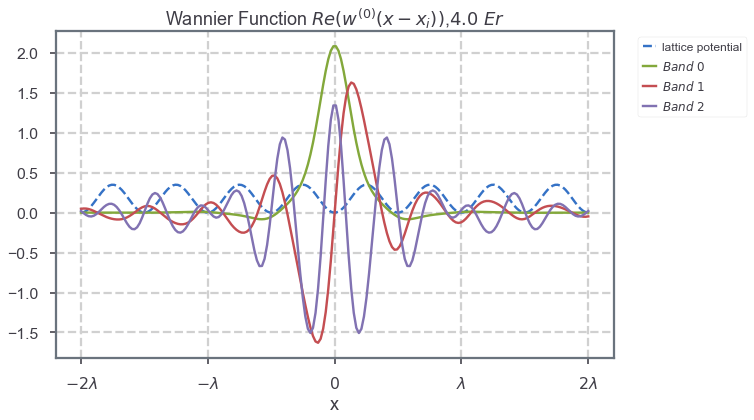

In [19]:
%%time
bandnum=11
xlist=np.linspace(-2,2,200)
V0=4
#plt.grid(True)
nlist=[0,1,2]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $Re(w^{(0)}(x-x_i))$,$%0.1f\\ Er$'%V0)
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for n in nlist:
    plt.plot(xlist,np.real(WannierState(V0,n,xlist,0.,bandnum=bandnum))/np.sqrt(integrate.simps(np.abs(WannierState(v,n,xlist,0,bandnum=bandnum))**2,xlist)),'-',label='$Band\\ %d$'%n)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 3.12 s, sys: 78.3 ms, total: 3.2 s
Wall time: 1.87 s


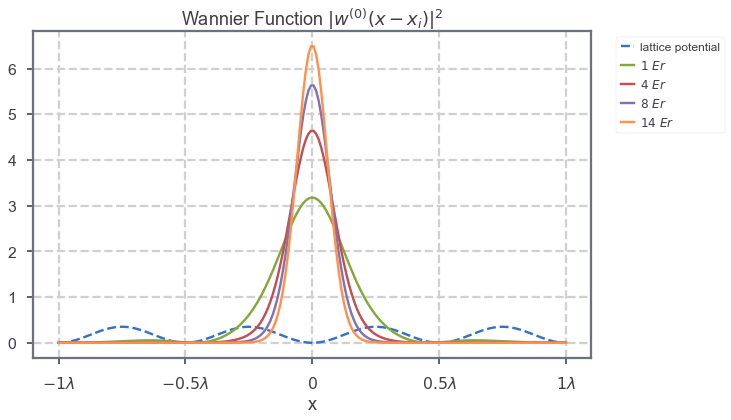

In [20]:
%%time
bandnum=11
xlist=np.linspace(-1,1,200)
#plt.grid(True)
vlist=[1,4,8,14]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $|w^{(0)}(x-x_i)|^2$')
plt.xticks(np.linspace(-1,1,5),('$-1\lambda$','$-0.5\lambda$','$0$','$0.5\lambda$','$1\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for v in vlist:
    plt.plot(xlist,(np.abs(WannierState(v,0,xlist,0.,bandnum=bandnum)))**2/integrate.simps(np.abs(WannierState(v,n,xlist,0,bandnum=bandnum))**2,xlist),'-',label='$%1.0f\\ Er$'%v)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

In [138]:
cst.Boltzmann*1*10**-9/cst.h

20.836612225125226